## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [70]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [71]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [72]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [73]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [74]:
df['converted'].mean() * 100

11.96591935560551

e. The number of times the `new_page` and `treatment` don't line up.

In [75]:
df[(df['landing_page'] == 'new_page') & (df['group'] != 'treatment')]['user_id'].count() + df[(df['landing_page'] != 'new_page') & (df['group'] == 'treatment')]['user_id'].count()

3893

f. Do any of the rows have missing values?

In [76]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [77]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
df2 = df.drop(df[((df['landing_page'] == 'new_page') & (df['group'] != 'treatment')) | ((df['landing_page'] != 'new_page') & (df['group'] == 'treatment'))].index)

In [78]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [79]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [80]:
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [81]:
df2[df2['user_id'].duplicated(keep = False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [82]:
# Remove one of the rows with a duplicate user_id..
# Hint: The dataframe.drop_duplicates() may not work in this case because the rows with duplicate user_id are not entirely identical. 
df2 = df2.drop(index = 2893)
# Check again if the row with a duplicate user_id is deleted or not
sum(df2.duplicated())

0

In [83]:
df2.shape[0]

290584

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [84]:
prob1 = df2['converted'].mean() * 100
print(prob1, '%')

11.959708724499627 %


b. Given that an individual was in the `control` group, what is the probability they converted?

In [85]:
# Get the converted column where group column value is control, then calsulate the mean
prob2 = df2['converted'][df2['group'] == 'treatment'].mean() * 100
print(prob2, '%')

11.880806551510565 %


c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [86]:
# Get the converted column where group column value is treatment, then calsulate the mean
prob3 = df2['converted'][df2['group'] == 'treatment'].mean() * 100
print(prob3, '%')

11.880806551510565 %


d. What is the probability that an individual received the new page?

In [87]:
(df2['landing_page'] == 'new_page').mean()

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

- The chance to recieve the old page is equal to the chance to recieve the new page. So, it is important to consider other factors to decide whether the new tratment page leads to more conversations rate or not. 

So the answer is No, we don't have sufficient evidence.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

***answer:*** 

H0 : p_old = p_new (or H0 : p_old - p_new = 0)

H1 : p_new > p_old (or H1 : p_new - p_old > 0)

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [88]:
p_new = df2['converted'].mean()
p_new * 100

11.959708724499627

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [89]:
p_old = df.converted.mean()
p_old * 100

11.96591935560551

c. What is $n_{new}$?

In [90]:
n_new = df2.query("group == 'treatment'").shape[0]
n_new

145310

d. What is $n_{old}$?

In [91]:
n_old = df2[df2.group == 'control'].count() [0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [92]:
# Simulate a Sample for the treatment Group
new_page_converted = np.random.choice([1,0], size = n_new, p = [p_new, 1 - p_new]).mean()
new_page_converted

0.11991604156630652

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [93]:
# Simulate a Sample for the control Group
old_page_converted = np.random.choice([1,0], size = n_old, p = [p_old, 1 - p_old]).mean()
old_page_converted

0.11880997287883585

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [94]:
diff = new_page_converted - old_page_converted
diff

0.0011060686874706654

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [95]:
# Sampling distribution 
p_diffs = []
for _ in range(10000):
  new_page_converted = np.random.choice([1,0], size = n_new, p = [p_new, 1 - p_new]).mean()
  old_page_converted = np.random.choice([1,0], size = n_old, p = [p_old, 1 - p_old]).mean()
  p_diffs.append(new_page_converted - old_page_converted)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

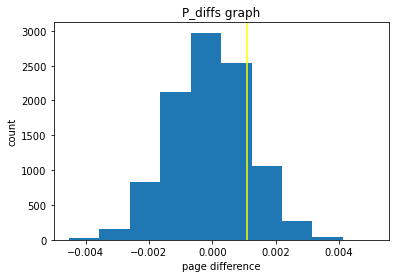

In [96]:
p_diffs = np.array(p_diffs)
plt.hist(p_diffs)
plt.title('P_diffs graph')
plt.xlabel('page difference')
plt.ylabel('count')
plt.axvline(x= diff, color = 'yellow', label = 'mean')

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [97]:
actual_diff = df2['converted'][df2['group'] == 'treatment'].mean() - df2['converted'][df2['group'] == 'control'].mean()
(actual_diff < p_diffs).mean() 

0.8911

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

- We calculated the p-value which is the probability of observing our statistic under null hypothesis. 
- the smaller p_value drives to reject the null hypothesis. But, the value is 0.8905. So, we can confidently say that we failed to reject null hypothesis.  
- As a result, we can not assume the new pages have more converted users than the old one
- The histogram shows the expected sampling distribution under null hypothesis


l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [98]:
import statsmodels.api as sm

convert_old = df2[df2['group'] == 'control']['converted'].sum()
convert_new = df2[df2['group'] == 'treatment']['converted'].sum()
n_old = df2[df2['group'] == 'control']['converted'].count()
n_new = df2[df2['group'] == 'treatment']['converted'].count()
convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145310)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [99]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
print('z_score = ', z_score, '& p_value = ', p_value)

z_score =  1.3109241984234394 & p_value =  0.9050583127590245


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

- The conversation rate of the new page is 1.31160 which is less than the critical value which is 1.96. So, we can't reject the null hyposesis.
- In addition, the positive z-score shows that the data point is on the right side of the line of the bell curve.
- About the P_value: it is 0.9052 which is almost equal to the value we have calculated earlier in 'j'. So, we can confidently say we failed to reject the null hypthesis

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

***Answer*** :Since we are dealing with categorical variables(converted vs non-converted)which predicts the probability between 0 and 1, the 'Logistic regression' will be used in this case


b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [100]:
#  create a column for the intercept
df2['intercept'] = 1
# create a dummy variable column for which page each user received(old or new)
df2[['new', 'old']] = pd.get_dummies(df['landing_page'])
# To check the results: df2.head()
# ab_page column, which is 1 when an individual receives the treatment and 0 if control.
df2['ab_page'] = pd.get_dummies(df['group'])['treatment']
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,new,old,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [101]:
import statsmodels.api as sm
# Logistic Regression --> using Logit function
model = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
# fitting model
result = model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [102]:
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Thu, 24 Mar 2022   Pseudo R-squ.:               8.077e-06
Time:                        15:27:54   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007


e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

* In Part II, hypothesis states that the conversations rate are equal fot the old page and the new one. So, we failed to reject null hypothesis:
 **$H_0$: $p_{old}$ - $p_{new}$ $>= 0$** ,,
 **$H_1$: $p_{old}$ - $p_{new}$ $< 0$** 
* The logistic regression showed that there is no relationship between the dependent and independent variables.
 **$H_0$: $p_{old}$ - $p_{new}$ $= 0$** ,,
 **$H_1$: $p_{old}$ - $p_{new}$ $!= 0$** 
* The logistic regression model's p-value which is 0.1899 differs from the p-value that have already computed in j and k because the model  assumed that there is an equal probability of the old and new page converting users.
* In addition, the logistic regression is a two-tailed test, whereas the computation of the partII is a one-tailed test

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

Advantages:
1. Identify other factors that may infuence the outcome(conversation rate)
2. Identify outliers

Disadvantages:
1. The model would be more sophisticated.
2. Due to the correlated errors, It may produce inaccurate results

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [103]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [104]:
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,new,old,ab_page
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1


In [105]:
# get the unique exist country
df_new['country'].unique()

array(['UK', 'US', 'CA'], dtype=object)

In [106]:
### Create the necessary dummy variables
df_new[['US', 'UK', 'CA']] = pd.get_dummies(df_new['country'])
df_new

,country,timestamp,group,landing_page,converted,intercept,new,old,ab_page,US,UK,CA
user_id,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
653118,US,2017-01-09 03:12:31.034796,control,old_page,0,1,0,1,0,0,0,1
878226,UK,2017-01-05 15:02:50.334962,control,old_page,0,1,0,1,0,0,1,0
799368,UK,2017-01-09 18:07:34.253935,control,old_page,0,1,0,1,0,0,1,0


In [107]:
model3 = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'CA', 'UK']])
result3 = model3.fit()
result3.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Thu, 24 Mar 2022   Pseudo R-squ.:               2.323e-05
Time:                        15:28:01   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA             0.0408      0.027      1.516      0.130      -0.012       0.093
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
==============================================================================
"""

Based on p-value result, we also can not see as though country has an impact on conversation rate.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [108]:
### Fit Your Linear Model And Obtain the Results
df_new['US_page'] = df_new['US'] * df_new['ab_page']
df_new['CA_page'] = df_new['CA'] * df_new['ab_page']

model_2 = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'UK', 'US' ,'US_page', 'CA_page']])
result_2 = model_2.fit()
result_2.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Thu, 24 Mar 2022   Pseudo R-squ.:               3.482e-05
Time:                        15:28:08   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page        0.0108      0.023      0.475      0.635      -0.034       0.056
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
US            -0.0175      0.038     -0.465      0.642      -0.091       0.056
US_page       -0.0783      0.057     -1.378      0.168      -0.190       0.033
CA_page       -0.0314      0.027     -1.181      0.238      -0.084       0.021
==============================================================================
"""

## Conclustions:
Through the project, we tried to decide whether the company should build a new page or keep the old one using:
- Probability: produced that both old and new pages have the same chance for users to be recieved.
- A/B Test: Using z_score and p_value, it is confirmed that we failed to reject null hypothesis as the eariler computed results.
- Regression: The result reached the silmilar earlier results that the countries haven't impact on the conversation rate.

we have to consider that the duration of the experiment is only 21 days and this is not enough time to run A/B test

## Resources:
- https://stackoverflow.com/questions/49814258/statsmodel-attributeerror-module-scipy-stats-has-no-attribute-chisqprob
- https://blog.minitab.com/en/adventures-in-statistics-2/how-to-correctly-interpret-p-values 
- https://stats.oarc.ucla.edu/other/mult-pkg/faq/general/faq-what-are-the-differences-between-one-tailed-and-two-tailed-tests/

<a id='conclusions'></a>
## Conclusions

Congratulations on completing the project! 

### Gather Submission Materials

Once you are satisfied with the status of your Notebook, you should save it in a format that will make it easy for others to read. You can use the __File -> Download as -> HTML (.html)__ menu to save your notebook as an .html file. If you are working locally and get an error about "No module name", then open a terminal and try installing the missing module using `pip install <module_name>` (don't include the "<" or ">" or any words following a period in the module name).

You will submit both your original Notebook and an HTML or PDF copy of the Notebook for review. There is no need for you to include any data files with your submission. If you made reference to other websites, books, and other resources to help you in solving tasks in the project, make sure that you document them. It is recommended that you either add a "Resources" section in a Markdown cell at the end of the Notebook report, or you can include a `readme.txt` file documenting your sources.

### Submit the Project

When you're ready, click on the "Submit Project" button to go to the project submission page. You can submit your files as a .zip archive or you can link to a GitHub repository containing your project files. If you go with GitHub, note that your submission will be a snapshot of the linked repository at time of submission. It is recommended that you keep each project in a separate repository to avoid any potential confusion: if a reviewer gets multiple folders representing multiple projects, there might be confusion regarding what project is to be evaluated.

It can take us up to a week to grade the project, but in most cases it is much faster. You will get an email once your submission has been reviewed. If you are having any problems submitting your project or wish to check on the status of your submission, please email us at dataanalyst-project@udacity.com. In the meantime, you should feel free to continue on with your learning journey by beginning the next module in the program.

In [109]:
from subprocess import call
call(['python', 'm', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

2